Basic Imports

In [89]:
import numpy as np
import sklearn
import math

In [90]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from keras.models import load_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

Processing the Dataset

In [91]:
ax_train_file = open('total_acc_x_train.txt', 'r')
ay_train_file= open('total_acc_y_train.txt','r')
az_train_file= open('total_acc_z_train.txt','r')

ax_train = []
ay_train = []
az_train = []

# labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
#           4:'SITTING', 5:'STANDING', 6:'LAYING'}

# # Loop through datasets
for x in ax_train_file:
    ax_train.append([float(ts) for ts in x.split()])
    
for y in ay_train_file:
    ay_train.append([float(ts) for ts in y.split()])
    
for z in az_train_file:
    az_train.append([float(ts) for ts in z.split()])

ax_train = np.array(ax_train)
ay_train = np.array(ay_train)
az_train = np.array(az_train)

In [92]:
ax_train.shape

(7352, 128)

In [93]:
ay_train.shape

(7352, 128)

In [94]:
X_train=np.sqrt(ax_train**2 + ay_train**2 + az_train**2)

In [95]:
X_train.shape

(7352, 128)

In [96]:
ax_test_file = open('total_acc_x_test.txt', 'r')
ay_test_file= open('total_acc_y_test.txt','r')
az_test_file= open('total_acc_z_test.txt','r')

ax_test = []
ay_test = []
az_test = []

# labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
#           4:'SITTING', 5:'STANDING', 6:'LAYING'}

# # Loop through datasets
for x in ax_test_file:
    ax_test.append([float(ts) for ts in x.split()])
    
for y in ay_test_file:
    ay_test.append([float(ts) for ts in y.split()])
    
for z in az_test_file:
    az_test.append([float(ts) for ts in z.split()])

ax_test = np.array(ax_test)
ay_test = np.array(ay_test)
az_test = np.array(az_test)

In [97]:
X_test=np.sqrt(ax_test**2 + ay_test**2 + az_test**2)

In [98]:
y_test = []

y_test_file = open('y_test.txt', 'r')

for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
    
y_test = np.array(y_test)


In [99]:
y_train = []

y_train_file = open('y_train.txt', 'r')

for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
    
y_train = np.array(y_train)

In [100]:
y_train.shape

(7352,)

In [101]:
y_test.shape

(2947,)

kNN on Raw Data

In [52]:
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            p = ProgressBar(shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    p.animate(dm_count)
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            p = ProgressBar(dm_size)
        
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)
        
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print(self,end="\r",flush=True)
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

In [32]:
m = KnnDtw(n_neighbors=1, max_warping_window=100)
m.fit(X_train[::10], y_train[::10])
label, proba = m.predict(X_test[::10])

In [102]:
label.shape

(295,)

In [103]:
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(label, y_test[::10],
                            target_names=[l for l in labels.values()]))

                    precision    recall  f1-score   support

           WALKING       0.94      0.87      0.90        54
  WALKING UPSTAIRS       0.83      0.63      0.72        63
WALKING DOWNSTAIRS       0.52      0.92      0.67        25
           SITTING       0.65      0.49      0.56        67
          STANDING       0.70      0.73      0.71        48
            LAYING       0.62      0.84      0.71        38

          accuracy                           0.71       295
         macro avg       0.71      0.75      0.71       295
      weighted avg       0.73      0.71      0.71       295



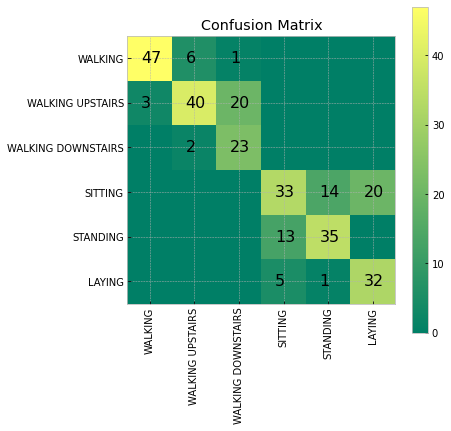

In [104]:
conf_mat = confusion_matrix(label, y_test[::10])

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(6), [l for l in labels.values()], rotation=90)
_ = plt.yticks(range(6), [l for l in labels.values()])

Custom Feature Engineering

In [105]:
import tsfel

In [106]:
x_train=np.zeros(X_train[:,0].size)

In [107]:
for i in range(X_train[:,0].size):
    x_train[i]=tsfel.feature_extraction.features.autocorr(X_train[i,:])

In [108]:
X_train=x_train

In [109]:
x_test=np.zeros(X_test[:,0].size)

In [110]:
for i in range(X_test[:,0].size):
    x_test[i]=tsfel.feature_extraction.features.autocorr(X_test[i,:])

In [111]:
X_train=X_train.reshape(-1,1)

In [112]:
X_test=x_test

In [113]:
X_test=X_test.reshape(-1,1)

In [114]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr  = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(random_state = 21,max_iter=1000)
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.6145232439769257

 -------------Classification Report-------------

              precision    recall  f1-score   support

           1       0.44      0.84      0.58       496
           2       0.34      0.05      0.09       471
           3       0.64      0.49      0.55       420
           4       0.61      0.56      0.58       491
           5       0.71      0.85      0.78       532
           6       0.84      0.82      0.83       537

    accuracy                           0.61      2947
   macro avg       0.60      0.60      0.57      2947
weighted avg       0.60      0.61      0.58      2947



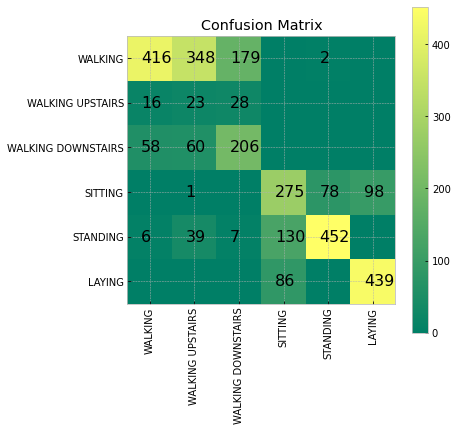

In [115]:
conf_mat = confusion_matrix(y_pred, y_test)

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(6), [l for l in labels.values()], rotation=90)
_ = plt.yticks(range(6), [l for l in labels.values()])

In [120]:
mse = sklearn.metrics.mean_squared_error(label,y_pred[::10])

rmse = math.sqrt(mse)

print(rmse)

0.9205746178983234


In [121]:
print("Accuracy:", accuracy_score(label, y_pred[::10]))

Accuracy: 0.6237288135593221


Feature Engineering on Features already extracted in the paper

In [116]:
x_train_file = open('UCI-HAR-Dataset/train/X_train.txt', 'r')
y_train_file = open('UCI-HAR-Dataset/train/y_train.txt', 'r')

x_test_file = open('UCI-HAR-Dataset/test/X_test.txt', 'r')
y_test_file = open('UCI-HAR-Dataset/test/y_test.txt', 'r')

# Create empty lists
x_train = []
y_train = []
x_test = []
y_test = []

# Mapping table for classes
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

# Loop through datasets
for x in x_train_file:
    x_train.append([float(ts) for ts in x.split()])
    
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
    
for x in x_test_file:
    x_test.append([float(ts) for ts in x.split()])
    
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
    
# Convert to numpy for efficiency
X_train = np.array(x_train)
y_train = np.array(y_train)
X_test = np.array(x_test)
y_test = np.array(y_test)

In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr  = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(random_state = 21,max_iter=10000)
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9548693586698337

 -------------Classification Report-------------

              precision    recall  f1-score   support

           1       0.94      0.99      0.97       496
           2       0.96      0.95      0.95       471
           3       0.99      0.94      0.97       420
           4       0.97      0.87      0.92       491
           5       0.89      0.97      0.93       532
           6       1.00      0.99      1.00       537

    accuracy                           0.95      2947
   macro avg       0.96      0.95      0.95      2947
weighted avg       0.96      0.95      0.95      2947



In [123]:
mse = sklearn.metrics.mean_squared_error(label,y_pred[::10])

rmse = math.sqrt(mse)

print(rmse)

0.7680042372764465


In [126]:
print("Accuracy:", accuracy_score(label, y_pred[::10]))

Accuracy: 0.7186440677966102


LSTM

In [127]:
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [128]:
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [129]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [130]:
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI-HAR-Dataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI-HAR-Dataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [131]:
def evaluate_LSTM_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 15, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network

    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    #model.save('/content/drive/My Drive/Colab Notebooks/LAR/LSTM.hdf5')
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy, model

In [132]:
def run_LSTM_experiment(repeats=1):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score,model = evaluate_LSTM_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('LSTM Model Accuracy: >%d: %.3f' % (r+1, score))
        scores.append(score)
    
    return model

In [136]:
LSTM_model = run_LSTM_experiment()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
LSTM Model Accuracy: >1: 89.786


In [137]:
trainX, trainy, testX, testy = load_dataset()
pred=LSTM_model.predict(testX)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [138]:
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

pred=np.argmax(pred, axis=1)
testy=np.argmax(testy, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(pred, testy,
                            target_names=[l for l in labels.values()]))

                    precision    recall  f1-score   support

           WALKING       0.89      1.00      0.94       443
  WALKING UPSTAIRS       0.92      0.87      0.89       497
WALKING DOWNSTAIRS       1.00      0.89      0.94       472
           SITTING       0.84      0.80      0.82       515
          STANDING       0.80      0.84      0.82       507
            LAYING       0.96      1.00      0.98       513

          accuracy                           0.90      2947
         macro avg       0.90      0.90      0.90      2947
      weighted avg       0.90      0.90      0.90      2947



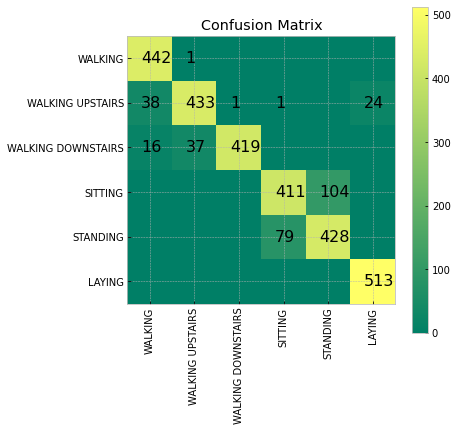

In [139]:
conf_mat = confusion_matrix(pred, testy)

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(6), [l for l in labels.values()], rotation=90)
_ = plt.yticks(range(6), [l for l in labels.values()])

In [142]:
mse = sklearn.metrics.mean_squared_error(label, pred[::10])

rmse = math.sqrt(mse)

print(rmse)

1.1108097519758935


In [141]:
print("Accuracy:", accuracy_score(label, pred[::10]))

Accuracy: 0.12203389830508475
